In [1]:
import os,sys
sys.path.append("../src/")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import visualizations as visu
import language as lang
import evaluation as eval

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Descrição do modelo
- Proprocessamento simples: TfidfVectorizer com ngram_range de 1 a 3 e 100 features.
- Modelos de ML (sklearn) com Cross-validation

## Loading data

In [2]:
# Loading the data
df_train = pd.read_csv('../data/Social Bias Frames/SBIC.v2.trn.csv')
df_valid = pd.read_csv('../data/Social Bias Frames/SBIC.v2.dev.csv')
df_test = pd.read_csv('../data/Social Bias Frames/SBIC.v2.tst.csv')

## Data Preparation:

In [3]:
target_col = 'targetCategory'

In [4]:
print('train data:', df_train.shape)
print('valid data:', df_valid.shape)
print('test data:', df_test.shape)

df_train[target_col].value_counts(dropna=False)

train data: (112900, 19)
valid data: (16738, 19)
test data: (17501, 19)


NaN         70406
race        14987
gender      10872
culture      8843
victim       2680
disabled     2350
social       1730
body         1032
Name: targetCategory, dtype: int64

In [5]:
# Dropping nan values:
df_train = df_train.dropna(subset=[target_col]).reset_index(drop=True)
df_valid = df_valid.dropna(subset=[target_col]).reset_index(drop=True)
df_test = df_test.dropna(subset=[target_col]).reset_index(drop=True)

print('train data:', df_train.shape)
print('valid data:', df_valid.shape)
print('test data:', df_test.shape)

train data: (42494, 19)
valid data: (8166, 19)
test data: (9200, 19)


In [6]:
# Concating train and valid dataframes and splitting X and y arrays:
df_train = pd.concat([df_train, df_valid], axis=0).reset_index(drop=True)

X_train = df_train.drop(columns=[target_col])
y_train = df_train[[target_col]]

X_test = df_test.drop(columns=[target_col])
y_test = df_test[[target_col]]

print('train data:', X_train.shape)
print('valid data:', X_test.shape)

train data: (50660, 18)
valid data: (9200, 18)


In [7]:
# Encoding the y targets:
le = LabelEncoder()
y_train[target_col] = le.fit_transform(y_train[target_col])
y_test[target_col] = le.transform(y_test[target_col])

<ipython-input-7-b59cab9b584f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[target_col] = le.fit_transform(y_train[target_col])
<ipython-input-7-b59cab9b584f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test[target_col] = le.transform(y_test[target_col])


## Pre-processing

In [8]:
# Encoding text columns:
en_stp_words = stopwords.words('english')

def column_vectorizer(df_train, df_test, col, max_features=100, stop_words=stopwords.words('english')):
    corpus = df_train[col].values
    vectorizer = TfidfVectorizer(strip_accents='unicode',
                                 lowercase=True,
                                 stop_words=stop_words,
                                 max_features=max_features,
                                 ngram_range=(1, 3))
    vectorizer.fit(corpus)

    df_train_tfidf = vectorizer.transform(df_train[col])
    tfidf_cols = [f'tfidf_{col}_{i}' for i in range(df_train_tfidf.shape[1])]
    df_train_tfidf = pd.DataFrame(df_train_tfidf.toarray(), columns=tfidf_cols)
    df_train = pd.concat([df_train, df_train_tfidf], axis=1)
    df_test_tfidf = vectorizer.transform(df_test[col])
    df_test_tfidf = pd.DataFrame(df_test_tfidf.toarray(), columns=tfidf_cols)
    df_test = pd.concat([df_test, df_test_tfidf], axis=1)
    
    return df_train, df_test, tfidf_cols
    
# post text:
X_train, X_test, tfidf_cols = column_vectorizer(X_train, X_test, 'post', max_features=100, stop_words=en_stp_words)


In [9]:
X_train

,whoTarget,intentYN,sexYN,sexReason,offensiveYN,annotatorGender,annotatorMinority,sexPhrase,speakerMinorityYN,WorkerId,...,tfidf_post_90,tfidf_post_91,tfidf_post_92,tfidf_post_93,tfidf_post_94,tfidf_post_95,tfidf_post_96,tfidf_post_97,tfidf_post_98,tfidf_post_99
0,1.0,1.00,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.00,0.0,NaN,1.0,man,NaN,NaN,0.0,-500114755446676507,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.00,0.0,NaN,1.0,woman,NaN,NaN,0.0,7912096326098817047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.00,0.0,NaN,1.0,woman,NaN,NaN,0.0,7912096326098817047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.00,0.0,NaN,1.0,woman,NaN,NaN,0.0,7912096326098817047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50655,1.0,0.66,0.0,NaN,1.0,woman,NaN,NaN,0.0,3169503690680674782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50656,1.0,1.00,0.0,NaN,1.0,woman,NaN,NaN,0.0,955703508749055793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50657,1.0,1.00,0.0,NaN,1.0,woman,NaN,NaN,0.0,955703508749055793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50658,1.0,0.66,0.0,NaN,1.0,woman,NaN,NaN,0.0,-6352039173957003457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Encoding other columns:

# Features groups:
cat_features = []
num_float_features = []
passthrough_features = [] + tfidf_cols

# Features transformers:
cat_transformer = ('cat', Pipeline([('cat_imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='none')),
                                    ('one-hot', OneHotEncoder(handle_unknown='ignore'))]), cat_features)
num_float_transformer = ('num_float', Pipeline([('num_float_imputer', SimpleImputer(missing_values=np.nan, strategy='mean')), 
                                                ('num_float_scaler', MinMaxScaler()),]), num_float_features)
passthrough_transformer = ('passthrough', 'passthrough', passthrough_features)

transformers = [cat_transformer, num_float_transformer, passthrough_transformer]
feat_encoding = ColumnTransformer(transformers, remainder='drop')

In [11]:
# Pre-processing pipeline:
preprocessor = Pipeline([('features encoding', feat_encoding)])

In [12]:
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test.loc[:, X_train.columns])

## Model Training

In [13]:
n_jobs = 4
n_iter = 50

In [14]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [5, 10, 20, 30, 40, 50],
    'max_features': ["auto"],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [8, 10, 12, 14, 16],
    'n_estimators': [1, 5, 10, 20, 30, 40, 50],
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
clf_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                         cv=5, n_jobs=n_jobs, verbose=2, n_iter=n_iter)
clf_rf.fit(X_train_encoded, y_train)
rf_metrics = pd.DataFrame(clf_rf.cv_results_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [15]:
# Create the parameter grid based on the results of random search 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'max_iter': list(range(100, 800, 100)),
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# Create a based model
lrc = LogisticRegression()
# Instantiate the grid search model
clf_lrc = RandomizedSearchCV(estimator=lrc, param_distributions=param_grid,
                             cv=5, n_jobs=n_jobs, verbose=2, n_iter=n_iter)
clf_lrc.fit(X_train_encoded, y_train)
lrc_metrics = pd.DataFrame(clf_lrc.cv_results_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.56993683 0.61514015 0.61545598        nan        nan
 0.61521911 0.61697592 0.36640347        nan        nan        nan
 0.61762732        nan 0.61693644 0.61502171        nan 0.36640347
 0.36640347        nan        nan 0.61292933 0.61693644        nan
 0.61660087        nan        nan 0.61794315 0.61705488        nan
        nan        nan 0.61514015        nan 0.36640347 0.60219108
 0.6021516         nan 0.61693644 0.61697592        nan 0.61794315
 0.61652191 0.61502171 0.61697592 0.60219108 0.61697592 0.61697592
 0.47526648 0.61553494]
  warnings.warn(
C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

In [16]:
# Create the parameter grid based on the results of random search 
param_grid = {'metric': ['minkowski', 'euclidean', 'manhattan'],
              'weights': ['uniform', 'distance'],
              'n_neighbors': np.array([3, 4, 5, 6, 7, 8, 9])}

# Create a based model
knn = KNeighborsClassifier()
# Instantiate the grid search model
clf_knn = RandomizedSearchCV(estimator=knn, param_distributions=param_grid,
                             cv=5, n_jobs=n_jobs, verbose=2, n_iter=n_iter)
clf_knn.fit(X_train_encoded, y_train)
knn_metrics = pd.DataFrame(clf_knn.cv_results_)

C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 42 is smaller than n_iter=50. Running 42 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 42 candidates, totalling 210 fits


C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


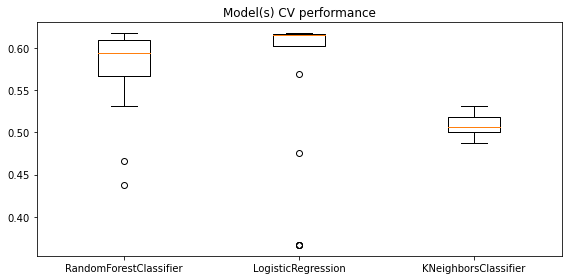

In [17]:
estimators_list = [clf_rf, clf_lrc, clf_knn]
visu.plot_estimators_cvperf(estimators_list)

In [18]:
# Selecting the optimal model and Re-fiting with the whole training dataset:
estimators_cvperf = [pd.DataFrame(estimator.cv_results_)['mean_test_score'].max() for estimator in estimators_list]
clf_opt = estimators_list[np.argmax(estimators_cvperf)]


model = clf_opt.best_estimator_.fit(X_train_encoded, y_train)
model

C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(C=10, max_iter=300, penalty='l1', solver='liblinear')

## Evaluating the model

In [19]:
TARGET_NAMES = le.classes_
TARGET_NAMES

array(['body', 'culture', 'disabled', 'gender', 'race', 'social',
       'victim'], dtype=object)

C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classes evaluated: ['body', 'culture', 'disabled', 'gender', 'race', 'social', 'victim']
Correctly classified......: 6264/9200
Accuracy (simple) ........: 0.68
Balanced acc.  ...........: 0.38
Balanced acc. (adjusted)..: 0.27
Acc. norm (Recall avgs) ..: 0.37
Precision = tp / (tp + fp): [0.2  0.57 0.39 0.71 0.76 0.   0.33] -> accuracy of positive predictions
Recall    = tp / (tp + fn): [0.01 0.73 0.24 0.73 0.8  0.   0.11] -> sensibility (true positive rate)
F1 score .................: [0.02 0.64 0.3  0.72 0.78 0.   0.17] -> harmonic mean


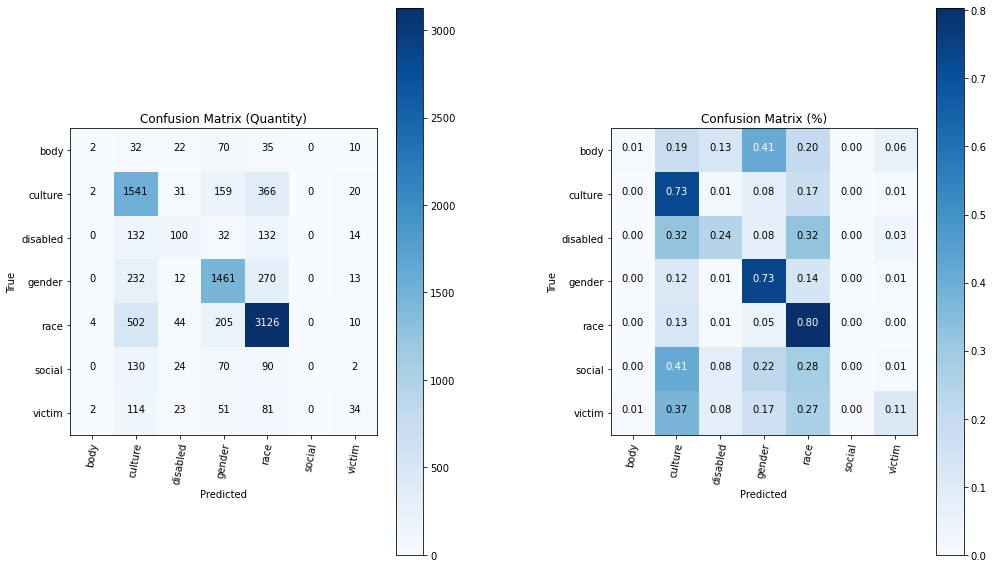

,accuracy,balanced_accuracy,balanced_accuracy adjusted,precision,recall,f1_score
0,0.68,0.38,0.27,0.20,0.01,0.02
1,0.68,0.38,0.27,0.57,0.73,0.64
2,0.68,0.38,0.27,0.39,0.24,0.30
3,0.68,0.38,0.27,0.71,0.73,0.72
4,0.68,0.38,0.27,0.76,0.80,0.78
5,0.68,0.38,0.27,0.00,0.00,0.00
6,0.68,0.38,0.27,0.33,0.11,0.17


In [20]:
y_pred_test = model.predict(X_test_encoded)
y_true_test = y_test[target_col].values

results = eval.performance_measures(y_true_test, y_pred_test, TARGET_NAMES)
results = pd.DataFrame(results)
results

C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
../src\evaluation.py:1

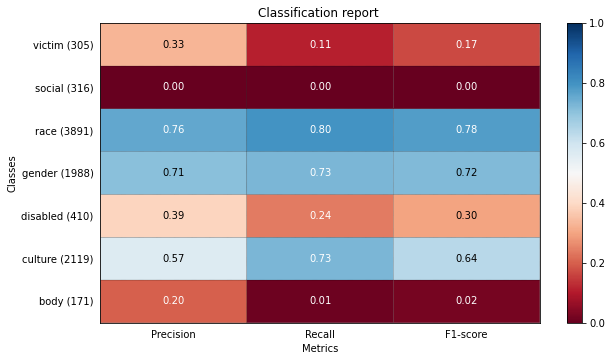

In [21]:
eval.plot_classification_report(classification_report(y_true_test, y_pred_test, target_names=TARGET_NAMES))